In [39]:
import numpy as np
import pandas as pd

ar = np.genfromtxt('../data/A/combined_traces/10uM_idl.csv', delimiter=',')

In [2]:
from sfkinetics import PopData

popdata = PopData(ar)

In [523]:
def fit_func(t, A, k, t0, b, c):
    return A*np.exp(-k*(t - t0)) + b*t + c

class ExpFit(object):
    """
    Creates and stores initial guess and bounds for fitting parameters based on provided data, then fits the data.
    We assume that the data includes only the decay and the start point of the decay happens within the first second  
    """
    def __init__(self, df, t0=None, lin=True):
        self.data = df
        t = df.time.to_numpy()
        y = df.state_occupancy.to_numpy()
        a_first = y[:5].mean()
        a_last = y[-5:].mean()
        idx = ['A', 'k', 't0', 'b', 'c']
        
        # Initial guess
        s = pd.Series(index = idx)
        s.A = a_first-a_last
        s.k = 0.1 * np.ptp(t)
        s.b = 0
        s.c = a_last
        
        # lower bounds
        lb = pd.Series(index = idx)
        lb.A = 0 if s.A > 0 else -1
        lb.k = 0
        lb.b = -1 if lin else -1e-9
        lb.c = 0

        # upper bounds
        ub = pd.Series(index = idx)
        ub.A = 1 if s.A > 0 else 0
        ub.k = 1/(t[1] - t[0])
        ub.b = 1 if lin else 1e-9
        ub.c = 1
        
        if t0 is None:
            s.t0 = t[0] + 0.5
            lb.t0 = t[0] - 1
            ub.t0 = t[0] + 1
        else:
            s.t0 = t0
            lb.t0 = t0 - 1e-9
            ub.t0 = t0 + 1e-9
        
        self.initial_guess = s
        self.lower_bounds = lb
        self.upper_bounds = ub
        
        self.bounds = (list(self.lower_bounds), list(self.upper_bounds))
        
        params, self.covariance = curve_fit(fit_func, t, y, p0=list(self.initial_guess), bounds=self.bounds)
        self.params = pd.Series(params, index=idx)
    
    def predict(self, t=None):
        if t is None:
            t = self.data.time.to_numpy()
        return pd.DataFrame(dict(time=t, state_occupancy=fit_func(np.array(t), **self.params)))

    def __repr__(self):
        return str(self.params.round(3)).rstrip("\ndtype: float64")


In [530]:
from scipy.optimize import curve_fit
from plotnine import ggplot, geom_line, aes, xlab, ylab, coord_cartesian, geom_point, geom_label, annotate, geom_boxplot
import textwrap


# Define the custom fitting function combining exponential decay and linear change
def fit_func(t, A, k, t0, b, c):
    return A*np.exp(-k*(t - t0)) + b*t + c

class TransitionFitting:
    def __init__(self, popdata, t1=5, t2=25, t3=40, time_margin = 0.2, lin=True):
        self.data = popdata.data
        self.t1 = t1
        self.t2 = t2
        self.t3 = t3
        
        self.fit1 = ExpFit(self.data.query(f"{self.t1}-{time_margin} <= time and time <= {self.t2}+{time_margin}"), lin=lin)
        self.fit2 = ExpFit(self.data.query(f"{self.t2}-{time_margin} <= time and time <= {self.t3}+{time_margin}"), lin=lin)
        
        p1 = self.fit1.params
        p2 = self.fit2.params
        self.k = pd.Series(dict(
            A1=p1.A,
            kobs=p1.k,
            t1=p1.t0,
            A2=p2.A,
            koff=p2.k,
            t2=p2.t0,
        ))
        
    def __repr__(self):
        return ("Fitting result for FRET transition rates\n"
                + str(self.fit1)
                + str(self.fit2)
                )
    
    def _gg_data_layer(self):
        return [geom_point(aes(x='time', y='state_occupancy'), data=self.data)]
    
    def _gg_fit1_layer(self):
        f = self.fit1
        return [
            geom_line(aes(x='time', y='state_occupancy'), data=f.predict(), color='red'),
            geom_label(aes(x=self.t1 + 5, y=0.9), label=str(f), ha='left', va='top'),
                ]
    
    def _gg_fit2_layer(self):
        f = self.fit2
        return [
            geom_line(aes(x='time', y='state_occupancy'), data=f.predict(), color='red'),
            geom_label(aes(x=self.t2 + 5, y=self.fit1.params.c), label = str(f), ha='left', va='bottom'),
                ]
    
    def gglayer(self):
        return [
            *self._gg_data_layer(),
            *self._gg_fit1_layer(),
            *self._gg_fit2_layer(),
            xlab("Time, s"),
            ylab("State occupancy"),
        ]

    def ggplot(self):
        plot = ggplot()
        for layer in self.gglayer():
            plot += layer
        return plot + coord_cartesian(xlim=(0, self.t3))

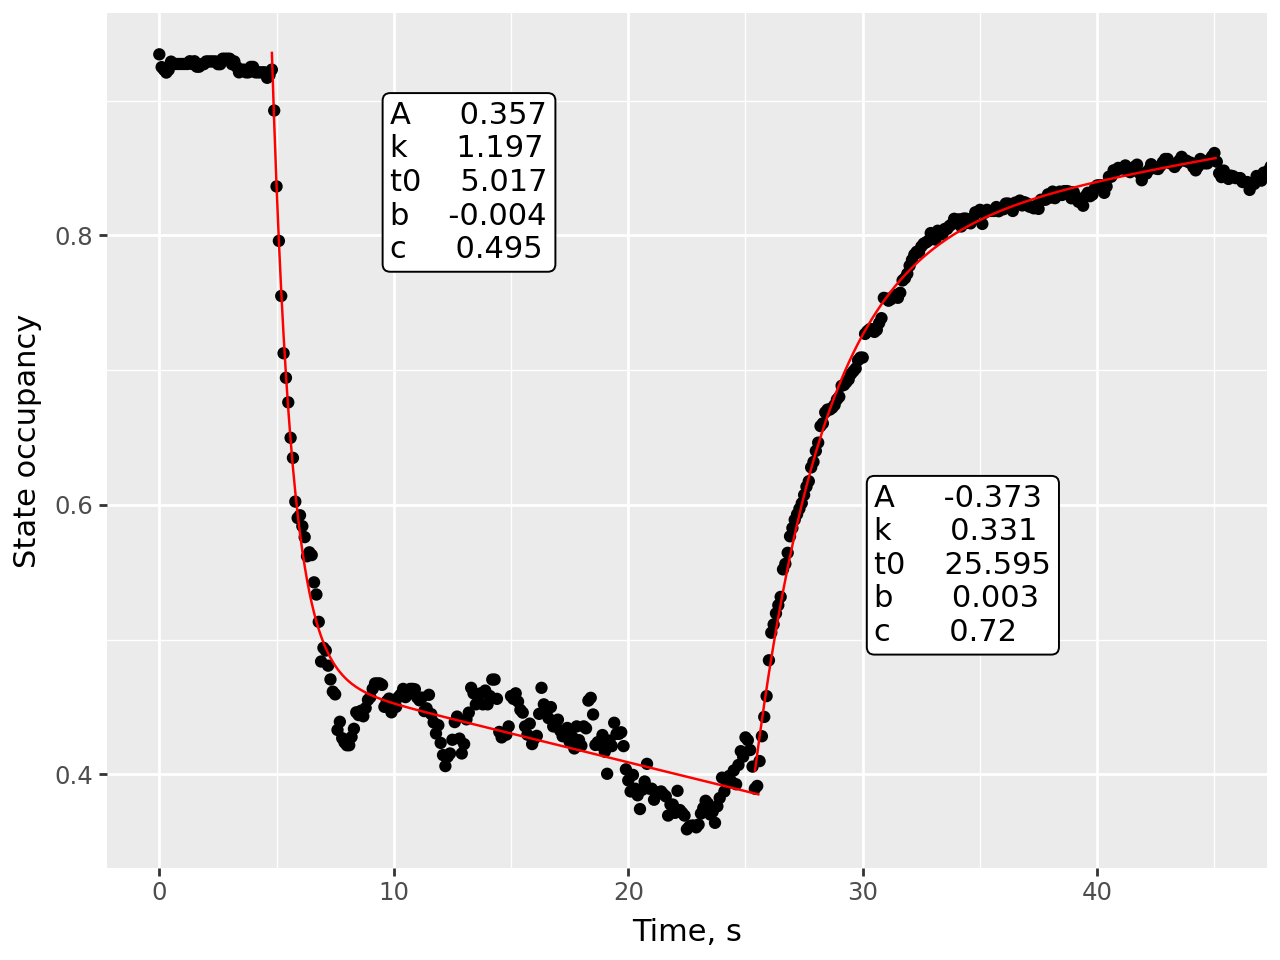

In [554]:
popdata = PopData(ar[np.random.choice(ar.shape[0], 500, replace=True)])
tf = TransitionFitting(popdata, t1=4.85, t2=25.5, t3=45, time_margin=.1)
tf.ggplot() 

In [537]:
# Bootstrap prototype

l = []
for i in range(500):
    popdata = PopData(ar[np.random.choice(ar.shape[0], 500, replace=True)])
    tf = TransitionFitting(popdata, t1=4.85, t2=25.4, t3=45, time_margin=.1)
    l.append(tf.k)
df = pd.DataFrame(l)
df

,A1,kobs,t1,A2,koff,t2
0,0.451791,0.864160,4.813816,-0.429890,0.360595,25.236826
1,0.459312,0.927691,4.746572,-0.460649,0.303892,25.277624
2,0.397061,0.984364,4.760439,-0.401956,0.307884,25.208441
3,0.456513,0.859598,4.796776,-0.389934,0.336404,25.143937
4,0.458233,0.882438,4.822982,-0.441488,0.322109,25.311645
...,...,...,...,...,...,...
495,0.422854,0.664059,4.890816,-0.383092,0.392228,25.203169
496,0.426001,0.891683,4.825062,-0.423750,0.259218,25.230470
497,0.419962,0.829482,4.804972,-0.430891,0.312802,25.325456
498,0.445093,0.597009,4.825705,-0.468112,0.258664,25.354515


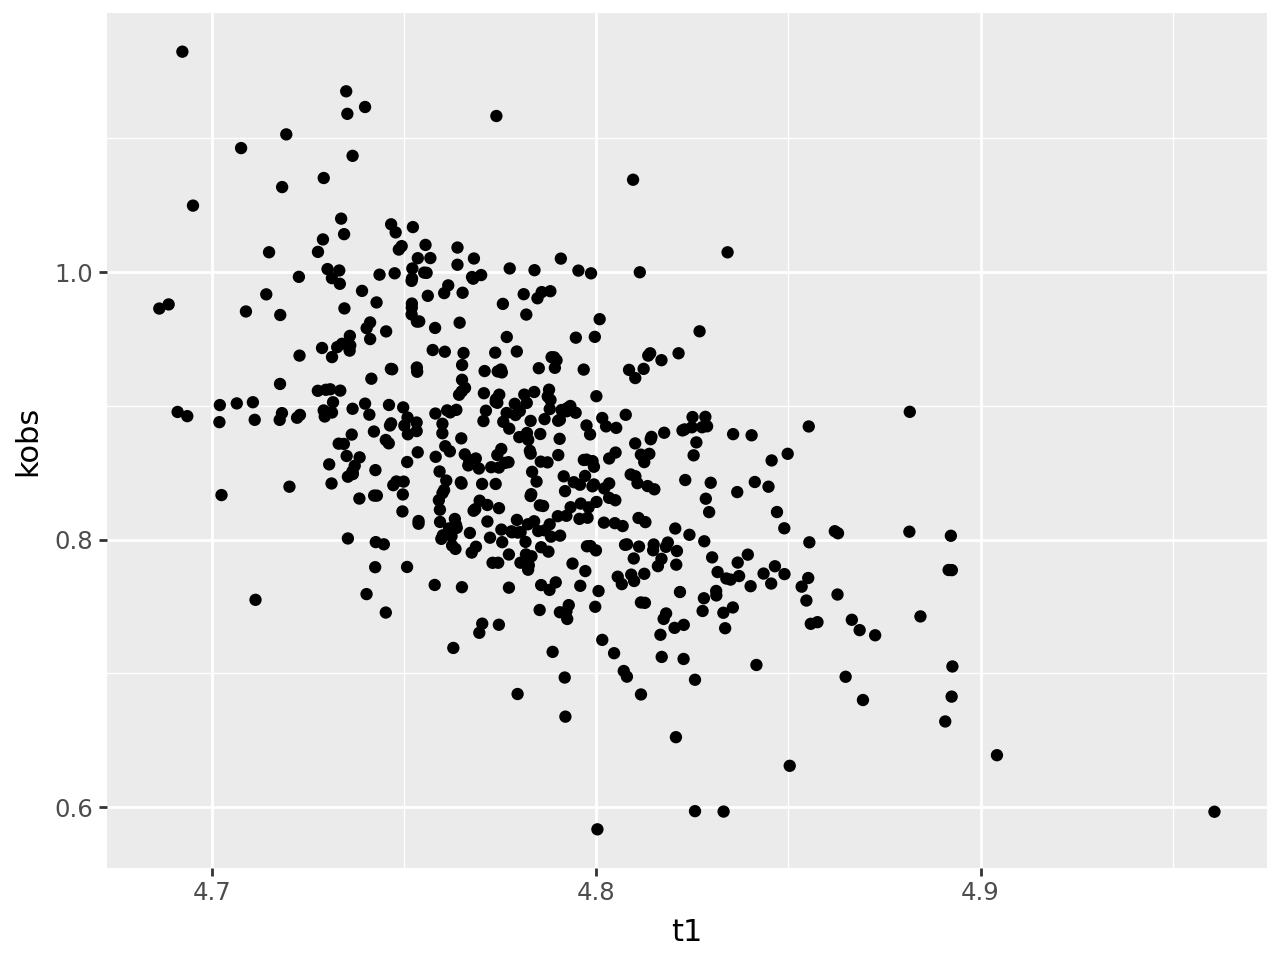

In [538]:
(ggplot(df)
  + geom_point(aes(x = 't1', y='kobs'))
 )